<a href="https://colab.research.google.com/github/Laurenyoshizuka/sample_churn_retention_analysis/blob/main/sample_churn_retention_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import pandas as pd
import numpy as np
import os
import sqlite3
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import Image, display
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

# Data loading and DB connection

In [ ]:
!git clone https://github.com/Laurenyoshizuka/sample_churn_retention_analysis.git

In [49]:
os.chdir('/content/sample_churn_retention_analysis')

cust_rev_mon = pd.read_csv('/content/sample_churn_retention_analysis/customer_revenue_monthly.csv', parse_dates=['MONTH'])
dim_cust = pd.read_csv('/content/sample_churn_retention_analysis/dim_customer.csv')
dim_serv = pd.read_csv('/content/sample_churn_retention_analysis/dim_service.csv')

In [ ]:
conn = sqlite3.connect(':memory:')

cust_rev_mon.to_sql('cust_rev_mon', conn, index=False, if_exists='replace')
dim_cust.to_sql('dim_cust', conn, index=False, if_exists='replace')
dim_serv.to_sql('dim_serv', conn, index=False, if_exists='replace')

# Quick overview of the csv data before starting analysis

In [51]:
def overview_of_dataframes(df1, df2, df3, name1='Customer Revenue Monthly Table', name2='Customer Dimension Table', name3='Service Dimension Table'):
    """
    Provides an overview of the 3 dataframes with basic info about the tables and summary statistics

    Parameters:
    df1, df2, df3 (pd.DataFrame): dfs to be summarized
    name1, name2, name3 (str): Optional aliases for better readibility

    Returns:
    None
    """
    dataframes = [df1, df2, df3]
    names = [name1, name2, name3]

    for df, name in zip(dataframes, names):
        print(f"--- {name} ---")
        print(f"Shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")
        print("Data Types:")
        print(df.dtypes)
        print("\nFirst 5 Rows:")
        print(df.head())
        print("\nSummary Statistics:")
        print(df.describe(include='all'))
        print("\nMissing Values:")
        print(df.isnull().sum())

        # Check for duplicates in month and customer_id since customers can have multiple services
        if name == name1:
            duplicate_count = df.duplicated(subset=['MONTH', 'CUSTOMER_ID']).sum()
            print(f"\nNumber of duplicate rows based on MONTH and CUSTOMER_ID: {duplicate_count}")

            if duplicate_count > 0:
                print("\nSample of duplicate rows:")
                duplicates = df[df.duplicated(subset=['MONTH', 'CUSTOMER_ID'], keep=False)]
                print(duplicates.head())

        print("\n" + "="*50 + "\n")


overview_of_dataframes(cust_rev_mon, dim_cust, dim_serv, 'Customer Revenue Monthly', 'Dimension Customer', 'Dimension Service')

--- Customer Revenue Monthly ---
Shape: (99393, 5)
Columns: ['MONTH', 'CUSTOMER_ID', 'SERVICE_ID', 'CONTRACTS', 'TOTAL_SAAS_REVENUE_USD']
Data Types:
MONTH                     datetime64[ns]
CUSTOMER_ID                        int64
SERVICE_ID                         int64
CONTRACTS                          int64
TOTAL_SAAS_REVENUE_USD           float64
dtype: object

First 5 Rows:
       MONTH  CUSTOMER_ID  SERVICE_ID  CONTRACTS  TOTAL_SAAS_REVENUE_USD
0 2023-10-01       199072          28         62                  6510.0
1 2023-12-01       473284          28          9                  1323.0
2 2023-11-01       180824          28          9                  1323.0
3 2023-12-01       174840          28         64                  9408.0
4 2023-09-01       158752          28         58                 10266.0

Summary Statistics:
                               MONTH    CUSTOMER_ID    SERVICE_ID  \
count                          99393   99393.000000  99393.000000   
mean   2023-09-17 0

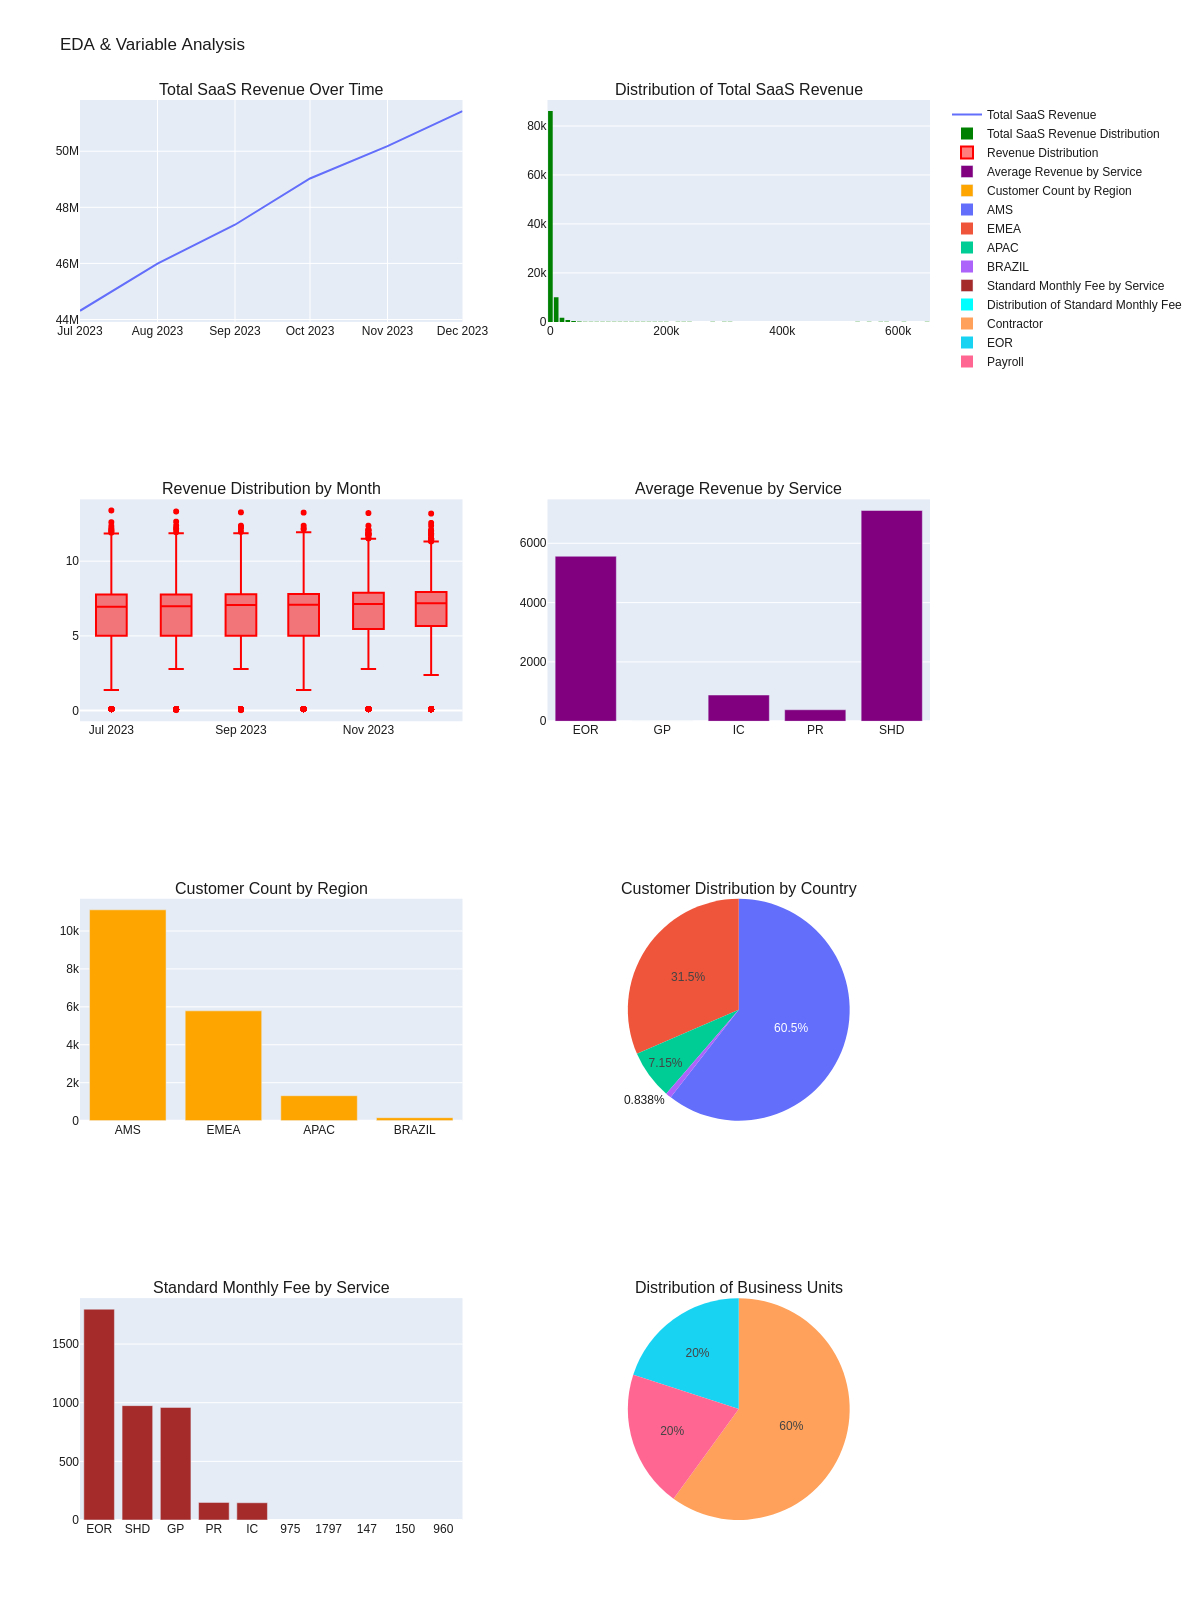

In [ ]:
def visualize_dataframes(df1, df2, df3, name1='Customer Revenue Monthly', name2='Customer Dimension', name3='Service Dimension'):
    """
    Generates visualizations for the three dataframes

    Parameters:
    df1, df2, df3 (pd.DataFrame): dfs to be visualized
    name1, name2, name3 (str): aliases for better readability

    Returns:
    None
    """
    fig = make_subplots(
        rows=4, cols=2,
        subplot_titles=[
            'Total SaaS Revenue Over Time',
            'Distribution of Total SaaS Revenue',
            'Revenue Distribution by Month',
            'Average Revenue by Service',
            'Customer Count by Region',
            'Customer Distribution by Country',
            'Standard Monthly Fee by Service',
            'Distribution of Business Units'
        ],
        specs=[[{"type": "xy"}, {"type": "xy"}],
               [{"type": "xy"}, {"type": "xy"}],
               [{"type": "xy"}, {"type": "domain"}],
               [{"type": "xy"}, {"type": "domain"}]]
    )

    if name1 == 'Customer Revenue Monthly':
        df_agg = df1.groupby('MONTH').agg({'TOTAL_SAAS_REVENUE_USD': 'sum'}).reset_index()
        trace1 = go.Scatter(x=df_agg['MONTH'], y=df_agg['TOTAL_SAAS_REVENUE_USD'], mode='lines', name='Total SaaS Revenue')

        trace2 = go.Histogram(x=df1['TOTAL_SAAS_REVENUE_USD'], nbinsx=100, marker_color='green', name='Total SaaS Revenue Distribution')

        df1['LOG_TOTAL_SAAS_REVENUE_USD'] = np.log1p(df1['TOTAL_SAAS_REVENUE_USD'].replace(0, 0.1))
        trace3 = go.Box(x=df1['MONTH'], y=df1['LOG_TOTAL_SAAS_REVENUE_USD'], marker_color='red', name='Revenue Distribution')

        df_revenue_service = df1.merge(dim_serv, left_on='SERVICE_ID', right_on='ID')
        df_revenue_service_grouped = df_revenue_service.groupby('NAME').agg({'TOTAL_SAAS_REVENUE_USD': 'mean'}).reset_index()
        trace4 = go.Bar(x=df_revenue_service_grouped['NAME'], y=df_revenue_service_grouped['TOTAL_SAAS_REVENUE_USD'], marker_color='purple', name='Average Revenue by Service')

        fig.add_trace(trace1, row=1, col=1)  # Scatter plot
        fig.add_trace(trace2, row=1, col=2)  # Histogram
        fig.add_trace(trace3, row=2, col=1)  # Box plot
        fig.add_trace(trace4, row=2, col=2)  # Bar plot

    if name2 == 'Customer Dimension':
        # Customer Count by Region
        region_counts = df2['REGION'].value_counts().reset_index()
        region_counts.columns = ['REGION', 'count']
        trace5 = go.Bar(x=region_counts['REGION'], y=region_counts['count'], marker_color='orange', name='Customer Count by Region')

        # Customer Distribution by Country
        trace6 = go.Pie(labels=df2['REGION'].value_counts().index, values=df2['REGION'].value_counts().values, name='Customer Distribution by Country')

        fig.add_trace(trace5, row=3, col=1)  # Bar plot
        fig.add_trace(trace6, row=3, col=2)  # Pie chart

    if name3 == 'Service Dimension':
        # Standard Monthly Fee by Service
        df_sorted = df3.sort_values(by='STANDARD_MONTHLY_FEE', ascending=False)
        trace7 = go.Bar(x=df_sorted['NAME'], y=df_sorted['STANDARD_MONTHLY_FEE'], marker_color='brown', name='Standard Monthly Fee by Service')

        # Distribution of Standard Monthly Fee
        trace8 = go.Histogram(x=df3['STANDARD_MONTHLY_FEE'], marker_color='cyan', name='Distribution of Standard Monthly Fee')

        # Customer Distribution by Business Unit
        business_unit_counts = df3['BUSINESS_UNIT'].value_counts().reset_index()
        business_unit_counts.columns = ['BUSINESS_UNIT', 'count']
        trace9 = go.Pie(labels=business_unit_counts['BUSINESS_UNIT'], values=business_unit_counts['count'], name='Distribution of Business Units')

        fig.add_trace(trace7, row=4, col=1)  # Bar plot
        fig.add_trace(trace8, row=4, col=1)  # Histogram
        fig.add_trace(trace9, row=4, col=2)  # Pie chart

    fig.update_layout(
        title_text="EDA & Variable Analysis",
        height=1600,
        width=1200,
        font=dict(
            family="Helvetica",
            size=12,
            color="#1b1b1b"
        ),
        showlegend=True
    )

    fig.write_image("eda.png")
    display(Image(filename="eda.png"))

visualize_dataframes(cust_rev_mon, dim_cust, dim_serv,
                     name1='Customer Revenue Monthly',
                     name2='Customer Dimension',
                     name3='Service Dimension')



---



# Task 1: SQL Query - Churn Rate Analysis
Write a SQL query to calculate the monthly churn rate for the past year.

$$
\text{Monthly Churn Rate} = \left( \frac{\text{Number of customers lost during the month}}{\text{Number of active customers in the previous month }} \right) \times 100
$$

* *Number of customers lost during month* : customers with 0 contracts in the month

* *Number of active customers in the previous month* : distinct count of customers having >= 1 contract in previous month

In [60]:
cursor = conn.cursor()

query = '''
WITH monthly_data AS (
    SELECT
        month
        ,customer_id
        ,total_contracts
        ,LAG(month, 1) OVER (PARTITION BY customer_id ORDER BY month) AS prev_month
        ,LAG(total_contracts, 1) OVER (PARTITION BY customer_id ORDER BY month) AS prev_total_contracts
    FROM (
          SELECT
              date(month) AS month
              ,customer_id
              ,SUM(contracts) AS total_contracts
          FROM
              cust_rev_mon
          GROUP BY
              month
              ,customer_id
    ) subquery
)
SELECT
    month
    ,COUNT(DISTINCT CASE WHEN total_contracts = 0 THEN customer_id END) AS lost_customers_count
    ,COUNT(DISTINCT CASE WHEN prev_total_contracts >= 1 THEN customer_id END) AS active_customers_count
    ,CASE
        WHEN COUNT(DISTINCT CASE WHEN prev_total_contracts >= 1 THEN customer_id END) > 0
        THEN (COUNT(DISTINCT CASE WHEN total_contracts = 0 THEN customer_id END) * 100.0 /
              COUNT(DISTINCT CASE WHEN prev_total_contracts >= 1 THEN customer_id END))
        ELSE NULL
    END AS churn_rate
FROM
    monthly_data
WHERE
    prev_month IS NOT NULL  -- omit july for churn calculation since no data from june to calculate active customers count
GROUP BY
    month
ORDER BY
    month
'''

cursor.execute(query)
rows = cursor.fetchall()

churn = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
print(tabulate(churn, headers="keys", tablefmt="plain"))
cursor.close()

    month         lost_customers_count    active_customers_count    churn_rate
 0  2023-08-01                      18                     12259      0.146831
 1  2023-09-01                      25                     12667      0.197363
 2  2023-10-01                      29                     13157      0.220415
 3  2023-11-01                      33                     13452      0.245317
 4  2023-12-01                      44                     13719      0.320723


Checking in pandas

In [57]:
monthly_data = cust_rev_mon.groupby(['MONTH', 'CUSTOMER_ID'])['CONTRACTS'].sum().reset_index()
monthly_data.rename(columns={'CONTRACTS': 'total_contracts'}, inplace=True)
monthly_data['prev_month'] = monthly_data.groupby('CUSTOMER_ID')['MONTH'].shift(1)
monthly_data['prev_total_contracts'] = monthly_data.groupby('CUSTOMER_ID')['total_contracts'].shift(1)
monthly_data = monthly_data.dropna(subset=['prev_month'])

lost_customers = monthly_data[monthly_data['total_contracts'] == 0]
lost_customers_count = lost_customers.groupby('MONTH')['CUSTOMER_ID'].nunique().reset_index()
lost_customers_count.rename(columns={'CUSTOMER_ID': 'lost_customers_count'}, inplace=True)

active_customers_prev_month = monthly_data[monthly_data['prev_total_contracts'] >= 1]
active_customers_count = active_customers_prev_month.groupby('MONTH')['CUSTOMER_ID'].nunique().reset_index()
active_customers_count.rename(columns={'CUSTOMER_ID': 'active_customers_count'}, inplace=True)

churn_data = pd.merge(lost_customers_count, active_customers_count, on='MONTH', how='left')
churn_data['churn_rate'] = (churn_data['lost_customers_count'] / churn_data['active_customers_count']) * 100
churn_data = churn_data.sort_values('MONTH')
print(churn_data)

       MONTH  lost_customers_count  active_customers_count  churn_rate
0 2023-08-01                    18                   12259    0.146831
1 2023-09-01                    25                   12667    0.197363
2 2023-10-01                    29                   13157    0.220415
3 2023-11-01                    33                   13452    0.245317
4 2023-12-01                    44                   13719    0.320723


*Although there's an upward trend in lost customers, we're not looking at which services are losing customers...*

In [61]:
cursor = conn.cursor()

query = '''
WITH monthly_data AS (
    SELECT
        month
        ,customer_id
        ,name
        ,total_contracts
        ,LAG(month, 1) OVER (PARTITION BY customer_id, name ORDER BY month) AS prev_month
        ,LAG(total_contracts, 1) OVER (PARTITION BY customer_id, name ORDER BY month) AS prev_total_contracts
    FROM (
        SELECT
            date(month) AS month
            ,customer_id
            ,name
            ,SUM(contracts) AS total_contracts
        FROM
            cust_rev_mon r
        LEFT JOIN
            dim_serv s
        ON
            r.service_id = s.id
        GROUP BY
            month
            ,customer_id
            ,name
    ) subquery
)
SELECT
    month
    ,name
    ,COUNT(DISTINCT CASE WHEN total_contracts = 0 THEN customer_id END) AS lost_customers_count
    ,COUNT(DISTINCT CASE WHEN prev_total_contracts >= 1 THEN customer_id END) AS active_customers_count
    ,CASE
        WHEN COUNT(DISTINCT CASE WHEN prev_total_contracts >= 1 THEN customer_id END) > 0
        THEN (COUNT(DISTINCT CASE WHEN total_contracts = 0 THEN customer_id END) * 100.0 /
              COUNT(DISTINCT CASE WHEN prev_total_contracts >= 1 THEN customer_id END))
        ELSE NULL
    END AS churn_rate
FROM
    monthly_data
WHERE
    prev_month IS NOT NULL  -- omit data with no previous month for churn calculation
GROUP BY
    month
    ,name
ORDER BY
    month
    ,name
'''

cursor.execute(query)
rows = cursor.fetchall()

churn_by_service = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
print(tabulate(churn_by_service, headers="keys", tablefmt="plain"))
cursor.close()

    month       name      lost_customers_count    active_customers_count    churn_rate
 0  2023-08-01  EOR                          0                      5913      0
 1  2023-08-01  IC                          16                      7814      0.204761
 2  2023-08-01  PR                           0                       691      0
 3  2023-08-01  SHD                          0                       366      0
 4  2023-09-01  EOR                          0                      6082      0
 5  2023-09-01  IC                          23                      8066      0.285148
 6  2023-09-01  PR                           0                       686      0
 7  2023-09-01  SHD                          0                       432      0
 8  2023-10-01  EOR                          0                      6353      0
 9  2023-10-01  GP                           0                         1      0
10  2023-10-01  IC                          26                      8274      0.314237
11  2023-10-

*Or which regions are losing customers,,,*

In [63]:
cursor = conn.cursor()

query = '''
WITH monthly_data AS (
    SELECT
        month
        ,customer_id
        ,region
        ,total_contracts
        ,LAG(month, 1) OVER (PARTITION BY customer_id, region ORDER BY month) AS prev_month
        ,LAG(total_contracts, 1) OVER (PARTITION BY customer_id, region ORDER BY month) AS prev_total_contracts
    FROM (
        SELECT
            date(month) AS month
            ,r.customer_id
            ,region
            ,SUM(contracts) AS total_contracts
        FROM
            cust_rev_mon r
        LEFT JOIN
            dim_cust c
        ON
            r.customer_id = c.customer_id
        GROUP BY
            month
            ,r.customer_id
            ,region
    ) subquery
)
SELECT
    month
    ,region
    ,COUNT(DISTINCT CASE WHEN total_contracts = 0 THEN customer_id END) AS lost_customers_count
    ,COUNT(DISTINCT CASE WHEN prev_total_contracts >= 1 THEN customer_id END) AS active_customers_count
    ,CASE
        WHEN COUNT(DISTINCT CASE WHEN prev_total_contracts >= 1 THEN customer_id END) > 0
        THEN (COUNT(DISTINCT CASE WHEN total_contracts = 0 THEN customer_id END) * 100.0 /
              COUNT(DISTINCT CASE WHEN prev_total_contracts >= 1 THEN customer_id END))
        ELSE NULL
    END AS churn_rate
FROM
    monthly_data
WHERE
    prev_month IS NOT NULL  -- omit data with no previous month for churn calculation
GROUP BY
    month
    ,region
ORDER BY
    month
    ,region
'''

cursor.execute(query)
rows = cursor.fetchall()

churn_by_region = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
print(tabulate(churn_by_region, headers="keys", tablefmt="plain"))
cursor.close()

    month       region      lost_customers_count    active_customers_count    churn_rate
 0  2023-08-01                                 1                       193      0.518135
 1  2023-08-01  AMS                           10                      7400      0.135135
 2  2023-08-01  APAC                           3                       847      0.354191
 3  2023-08-01  BRAZIL                         0                       104      0
 4  2023-08-01  EMEA                           4                      3715      0.107672
 5  2023-09-01                                 2                       201      0.995025
 6  2023-09-01  AMS                           12                      7628      0.157315
 7  2023-09-01  APAC                           2                       883      0.226501
 8  2023-09-01  BRAZIL                         0                       103      0
 9  2023-09-01  EMEA                           9                      3852      0.233645
10  2023-10-01                     

In [64]:
cursor = conn.cursor()

query = '''
WITH monthly_data AS (
    SELECT
        month
        ,customer_id
        ,region
        ,name
        ,total_contracts
        ,LAG(month, 1) OVER (PARTITION BY customer_id, region, name ORDER BY month) AS prev_month
        ,LAG(total_contracts, 1) OVER (PARTITION BY customer_id, region, name ORDER BY month) AS prev_total_contracts
    FROM (
        SELECT
            date(month) AS month
            ,r.customer_id
            ,region
            ,name
            ,SUM(contracts) AS total_contracts
        FROM
            cust_rev_mon r
        LEFT JOIN
            dim_cust c
        ON
            r.customer_id = c.customer_id
        LEFT JOIN
            dim_serv s
        ON
            r.service_id = s.id
        GROUP BY
            month
            ,r.customer_id
            ,region
            ,name
    ) subquery
)
SELECT
    month
    ,region
    ,name
    ,COUNT(DISTINCT CASE WHEN total_contracts = 0 THEN customer_id END) AS lost_customers_count
    ,COUNT(DISTINCT CASE WHEN prev_total_contracts >= 1 THEN customer_id END) AS active_customers_count
    ,CASE
        WHEN COUNT(DISTINCT CASE WHEN prev_total_contracts >= 1 THEN customer_id END) > 0
        THEN (COUNT(DISTINCT CASE WHEN total_contracts = 0 THEN customer_id END) * 100.0 /
              COUNT(DISTINCT CASE WHEN prev_total_contracts >= 1 THEN customer_id END))
        ELSE NULL
    END AS churn_rate
FROM
    monthly_data
WHERE
    prev_month IS NOT NULL  -- omit data with no previous month for churn calculation
GROUP BY
    month
    ,region
    ,name
ORDER BY
    month
    ,region
    ,name
'''

cursor.execute(query)
rows = cursor.fetchall()

churn_by_regional_service = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
print(tabulate(churn_by_regional_service, headers="keys", tablefmt="plain"))
cursor.close()

     month       region    name      lost_customers_count    active_customers_count    churn_rate
  0  2023-08-01            EOR                          0                        56      0
  1  2023-08-01            IC                           1                       154      0.649351
  2  2023-08-01            PR                           0                         8      0
  3  2023-08-01            SHD                          0                         7      0
  4  2023-08-01  AMS       EOR                          0                      2959      0
  5  2023-08-01  AMS       IC                           9                      5342      0.168476
  6  2023-08-01  AMS       PR                           0                       464      0
  7  2023-08-01  AMS       SHD                          0                       274      0
  8  2023-08-01  APAC      EOR                          0                       491      0
  9  2023-08-01  APAC      IC                           3            

Generating some graphs for EDA and data storytelling.

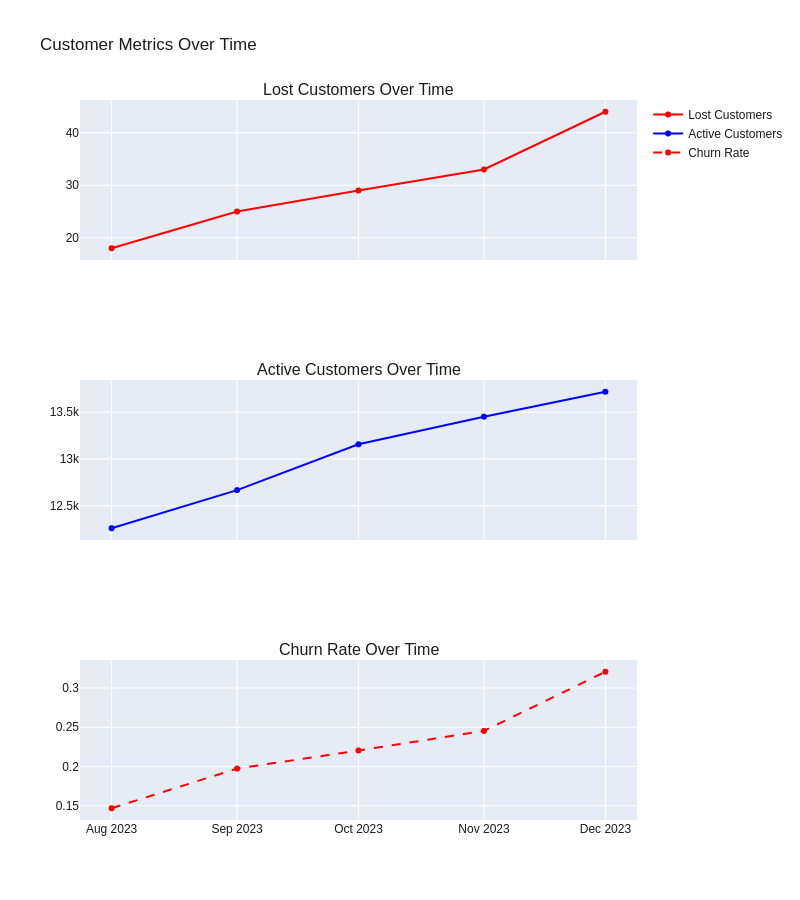

In [ ]:
fig = make_subplots(
    rows=3, cols=1, shared_xaxes=True,
    subplot_titles=('Lost Customers Over Time',
                    'Active Customers Over Time',
                    'Churn Rate Over Time')
)
fig.add_trace(
    go.Scatter(
        x=churn_data['MONTH'],
        y=churn_data['lost_customers_count'],
        mode='lines+markers',
        name='Lost Customers',
        line=dict(color='red')
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=churn_data['MONTH'],
        y=churn_data['active_customers_count'],
        mode='lines+markers',
        name='Active Customers',
        line=dict(color='blue')
    ),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(
        x=churn_data['MONTH'],
        y=churn_data['churn_rate'],
        mode='lines+markers',
        name='Churn Rate',
        line=dict(color='red', dash='dash')
    ),
    row=3, col=1
)
fig.update_layout(
    height=900,
    width=800,
    font=dict(
            family="Helvetica",
            size=12,
            color="#1b1b1b"
        ),
    title_text="Customer Metrics Over Time"
)
fig.write_image("customer_metrics_over_time.png")
display(Image(filename="customer_metrics_over_time.png"))

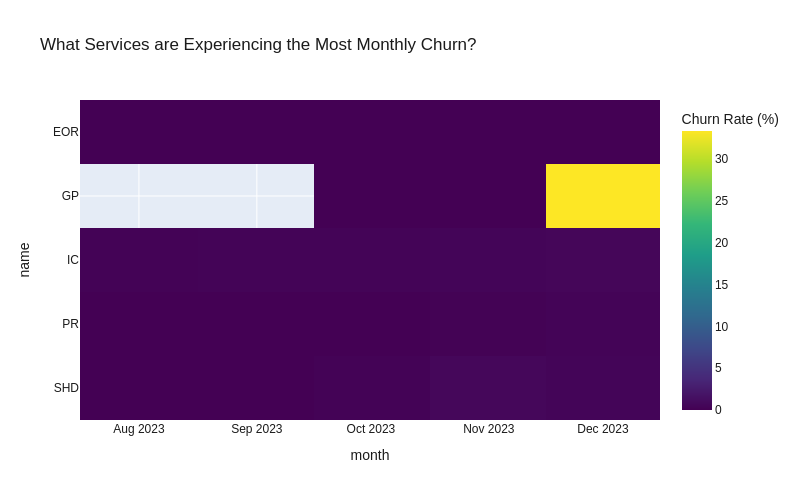

In [ ]:
fig = px.imshow(
    churn_by_service.pivot(index='name', columns='month', values='churn_rate'),
    title='What Services are Experiencing the Most Monthly Churn?',
    labels={'color': 'Churn Rate (%)'},
    color_continuous_scale='Viridis'
)
fig.update_layout(
    height=500,
    width=800,
    font=dict(
            family="Helvetica",
            size=12,
            color="#1b1b1b"
        )
)
fig.write_image("churn_by_bu.png")
display(Image(filename="churn_by_bu.png"))

It seems like the GP Payroll service was introduced in Sept, since we dont have and active customers unitl Oct. This service has the highest churn, but that's without standardizing the data, so this churn rate can be misinterpretted.

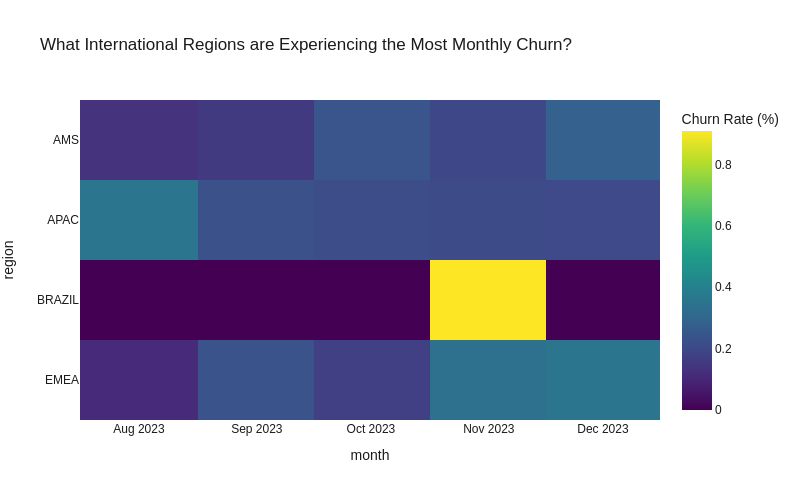

In [ ]:
fig = px.imshow(
    churn_by_region.pivot(index='region', columns='month', values='churn_rate'),
    title='What International Regions are Experiencing the Most Monthly Churn?',
    labels={'color': 'Churn Rate (%)'},
    color_continuous_scale='Viridis'
)
fig.update_layout(
    height=500,
    width=800,
    font=dict(
            family="Helvetica",
            size=12,
            color="#1b1b1b"
        )
)
fig.write_image("churn_by_region.png")
display(Image(filename="churn_by_region.png"))

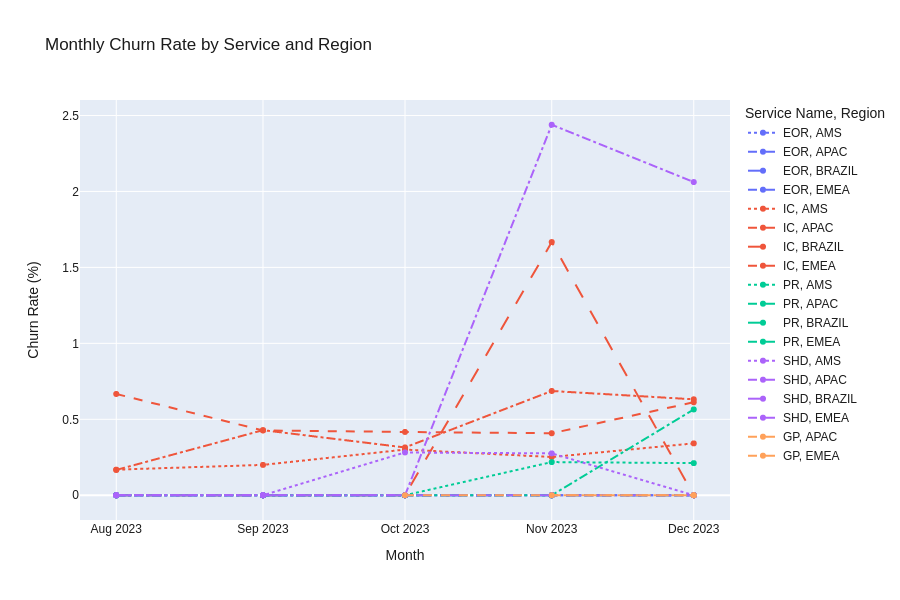

In [ ]:
churn_by_regional_service_filtered = churn_by_regional_service[ ~((churn_by_regional_service['name'] == 'GP') & (churn_by_regional_service['region'] == 'AMS'))]
fig = px.line(
    churn_by_regional_service_filtered,
    x='month',
    y='churn_rate',
    color='name',
    line_dash='region',
    markers=True,
    title='Monthly Churn Rate by Service and Region',
    labels={
        'month': 'Month',
        'churn_rate': 'Churn Rate (%)',
        'name': 'Service Name',
        'region': 'Region'
    }
)
fig.update_xaxes(
    dtick="M1",
    tickformat="%b %Y"
)
fig.update_layout(
    height=600,
    width=900,
    font=dict(
            family="Helvetica",
            size=12,
            color="#1b1b1b"
        )
)
fig.write_image("churn_by_regional_bu.png")
display(Image(filename="churn_by_regional_bu.png"))

After removing the outlier value (GP Payroll in AMS region), we have a better picture of churn rate at DEEL. The SHD Contractor service in the EMEA region was driving churn in the later half of 2023 (with a peak churn rate of 2.5% in November). This service has the second-highest service fee, which could be a potential reason customers are churning. This is followed by the IC Contractor service in the Brazil and EMEA regions.  



---



# Task 2: Analytical Insights - Retention Strategy
Develop SQL queries to extract insights on overall NRR, as well as NRR by Business Unit and Region.
NRR provides insights into how well a company is growing
its revenue from its existing customer base.

$$
\text{Monthly NRR} = \left( \frac{\text{𝐶𝑢𝑟𝑟𝑒𝑛𝑡 𝑀𝑜𝑛𝑡h 𝑆𝑎𝑎𝑆 𝑅𝑒𝑣𝑒𝑛𝑢𝑒 from existing active customers}}{\text{Previous 𝑀𝑜𝑛𝑡h 𝑆𝑎𝑎𝑆 𝑅𝑒𝑣𝑒𝑛𝑢𝑒 from existing active customers}} \right) \times 100
$$


- *Current Month SaaS Revenue from existing active customers* : Total SaaS revenue from
customers that were active in the this month
- *Previous Month SaaS revenue from existing active customer*s : Total SaaS revenue from
active customers last month
  - **Note it should be the same set of customers for the numerator and denominator**

In [65]:
cursor = conn.cursor()

query = '''
WITH monthly_data AS (
    SELECT
        month
        ,customer_id
        ,total_contracts
        ,total_SaaS_revenue
        ,LAG(total_contracts, 1) OVER (PARTITION BY customer_id ORDER BY month) AS prev_total_contracts
        ,LAG(total_SaaS_revenue, 1) OVER (PARTITION BY customer_id ORDER BY month) AS prev_total_SaaS_revenue
    FROM (
        SELECT
            date(month) AS month
            ,customer_id
            ,SUM(contracts) AS total_contracts
            ,SUM(TOTAL_SAAS_REVENUE_USD) AS total_SaaS_revenue
        FROM
            cust_rev_mon r
        LEFT JOIN
            dim_serv s
        ON
            r.service_id = s.id
        GROUP BY
            month
            ,customer_id
    ) subquery
)
SELECT
    month
    ,COUNT(DISTINCT customer_id) AS active_customers_count
    ,SUM(total_SaaS_revenue) AS current_total_SaaS_revenue
    ,SUM(prev_total_SaaS_revenue) AS previous_total_SaaS_revenue
    ,SUM(total_SaaS_revenue) / SUM(prev_total_SaaS_revenue) AS Monthly_NRR
FROM
    monthly_data
WHERE
    total_contracts >= 1
    AND prev_total_contracts >= 1
GROUP BY
    month
ORDER BY
    month
'''

cursor.execute(query)
rows = cursor.fetchall()

nrr_overall = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
print(tabulate(nrr_overall, headers="keys", tablefmt="plain"))
cursor.close()

    month         active_customers_count    current_total_SaaS_revenue    previous_total_SaaS_revenue    Monthly_NRR
 0  2023-08-01                     12243                   4.51907e+07                    4.39314e+07        1.02866
 1  2023-09-01                     12643                   4.63696e+07                    4.55369e+07        1.01829
 2  2023-10-01                     13131                   4.81466e+07                    4.70699e+07        1.02287
 3  2023-11-01                     13423                   4.94417e+07                    4.86014e+07        1.01729
 4  2023-12-01                     13682                   5.07003e+07                    4.98885e+07        1.01627


In [66]:
cursor = conn.cursor()

query = '''
WITH monthly_data AS (
    SELECT
        month
        ,customer_id
        ,business_unit
        ,total_contracts
        ,total_SaaS_revenue
        ,LAG(total_contracts, 1) OVER (PARTITION BY customer_id, business_unit ORDER BY month) AS prev_total_contracts
        ,LAG(total_SaaS_revenue, 1) OVER (PARTITION BY customer_id, business_unit ORDER BY month) AS prev_total_SaaS_revenue
    FROM (
        SELECT
            date(month) AS month
            ,customer_id
            ,business_unit
            ,SUM(contracts) AS total_contracts
            ,SUM(TOTAL_SAAS_REVENUE_USD) AS total_SaaS_revenue
        FROM
            cust_rev_mon r
        LEFT JOIN
            dim_serv s
        ON
            r.service_id = s.id
        GROUP BY
            month
            ,customer_id
            ,business_unit
    ) subquery
)
SELECT
    month
    ,business_unit
    ,COUNT(DISTINCT customer_id) AS active_customers_count
    ,SUM(total_SaaS_revenue) AS current_total_SaaS_revenue
    ,SUM(prev_total_SaaS_revenue) AS previous_total_SaaS_revenue
    ,CASE
        WHEN SUM(prev_total_SaaS_revenue) > 0 THEN
            SUM(total_SaaS_revenue) * 1.0 / SUM(prev_total_SaaS_revenue)
        ELSE
            0
    END AS Monthly_NRR
FROM
    monthly_data
WHERE
    total_contracts >= 1
    AND prev_total_contracts >= 1
GROUP BY
    month
    ,business_unit
ORDER BY
    month
    ,business_unit
'''

cursor.execute(query)
rows = cursor.fetchall()

nrr_business_unit = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
print(tabulate(nrr_business_unit, headers="keys", tablefmt="plain"))
cursor.close()

    month       business_unit      active_customers_count    current_total_SaaS_revenue    previous_total_SaaS_revenue    Monthly_NRR
 0  2023-08-01  Contractor                           7883                   1.08102e+07                    1.03861e+07        1.04083
 1  2023-08-01  EOR                                  5913                   3.41785e+07                    3.34582e+07        1.02153
 2  2023-09-01  Contractor                           8130                   1.12411e+07                    1.10214e+07        1.01993
 3  2023-09-01  EOR                                  6082                   3.49838e+07                    3.44341e+07        1.01596
 4  2023-10-01  Contractor                           8352                   1.169e+07                      1.14794e+07        1.01835
 5  2023-10-01  EOR                                  6353                   3.63146e+07                    3.54841e+07        1.0234
 6  2023-10-01  Payroll                                 1      

The Payroll service does not generate revenue, therefore its Monthly NRR is 0. As noted in the churn analysis, the Payroll service seems to be a fairly new service being offer as a freeium package in order to attract users.

In [67]:
cursor = conn.cursor()

query = '''
WITH monthly_data AS (
    SELECT
        month
        ,customer_id
        --,business_unit
        ,region
        ,total_contracts
        ,total_SaaS_revenue
        ,LAG(total_contracts, 1) OVER (PARTITION BY customer_id,region ORDER BY month) AS prev_total_contracts
        ,LAG(total_SaaS_revenue, 1) OVER (PARTITION BY customer_id,region ORDER BY month) AS prev_total_SaaS_revenue
    FROM (
        SELECT
            date(month) AS month
            ,r.customer_id
            --,business_unit
            ,region
            ,SUM(contracts) AS total_contracts
            ,SUM(TOTAL_SAAS_REVENUE_USD) AS total_SaaS_revenue
        FROM
            cust_rev_mon r
        LEFT JOIN
            dim_serv s
        ON
            r.service_id = s.id
        LEFT JOIN
            dim_cust c
        ON
            r.customer_id = c.customer_id
        GROUP BY
            month
            ,r.customer_id
            --,business_unit
            ,region
    ) subquery
)
SELECT
    month
    --,business_unit
    ,region
    ,COUNT(DISTINCT customer_id) AS active_customers_count
    ,SUM(total_SaaS_revenue) AS current_total_SaaS_revenue
    ,SUM(prev_total_SaaS_revenue) AS previous_total_SaaS_revenue
    ,CASE
        WHEN SUM(prev_total_SaaS_revenue) > 0 THEN
            SUM(total_SaaS_revenue) * 1.0 / SUM(prev_total_SaaS_revenue)
        ELSE
            0
    END AS Monthly_NRR
FROM
    monthly_data
WHERE
    total_contracts >= 1
    AND prev_total_contracts >= 1
GROUP BY
    month
    --,business_unit
    ,region
ORDER BY
    month
    --,business_unit
    ,region
'''

cursor.execute(query)
rows = cursor.fetchall()

nrr_region = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
print(tabulate(nrr_region, headers="keys", tablefmt="plain"))

    month       region      active_customers_count    current_total_SaaS_revenue    previous_total_SaaS_revenue    Monthly_NRR
 0  2023-08-01                                 193              517864                         518309                 0.99914
 1  2023-08-01  AMS                           7390                   2.53037e+07                    2.45418e+07       1.03105
 2  2023-08-01  APAC                           844                   3.39503e+06                    3.26001e+06       1.04142
 3  2023-08-01  BRAZIL                         104              366973                         335131                 1.09502
 4  2023-08-01  EMEA                          3712                   1.56071e+07                    1.52762e+07       1.02166
 5  2023-09-01                                 200              537806                         529954                 1.01482
 6  2023-09-01  AMS                           7616                   2.59212e+07                    2.55914e+07      

In [68]:
cursor = conn.cursor()

query = '''
WITH monthly_data AS (
    SELECT
        month
        ,customer_id
        ,business_unit
        ,region
        ,total_contracts
        ,total_SaaS_revenue
        ,LAG(total_contracts, 1) OVER (PARTITION BY customer_id,business_unit,region ORDER BY month) AS prev_total_contracts
        ,LAG(total_SaaS_revenue, 1) OVER (PARTITION BY customer_id,business_unit,region ORDER BY month) AS prev_total_SaaS_revenue
    FROM (
        SELECT
            date(month) AS month
            ,r.customer_id
            ,business_unit
            ,region
            ,SUM(contracts) AS total_contracts
            ,SUM(TOTAL_SAAS_REVENUE_USD) AS total_SaaS_revenue
        FROM
            cust_rev_mon r
        LEFT JOIN
            dim_serv s
        ON
            r.service_id = s.id
        LEFT JOIN
            dim_cust c
        ON
            r.customer_id = c.customer_id
        GROUP BY
            month
            ,r.customer_id
            ,business_unit
            ,region
    ) subquery
)
SELECT
    month
    ,business_unit
    ,region
    ,COUNT(DISTINCT customer_id) AS active_customers_count
    ,SUM(total_SaaS_revenue) AS current_total_SaaS_revenue
    ,SUM(prev_total_SaaS_revenue) AS previous_total_SaaS_revenue
    ,CASE
        WHEN SUM(prev_total_SaaS_revenue) > 0 THEN
            SUM(total_SaaS_revenue) * 1.0 / SUM(prev_total_SaaS_revenue)
        ELSE
            0
    END AS Monthly_NRR
FROM
    monthly_data
WHERE
    total_contracts >= 1
    AND prev_total_contracts >= 1
GROUP BY
    month
    ,business_unit
    ,region
ORDER BY
    month
    ,business_unit
    ,region
'''

cursor.execute(query)
rows = cursor.fetchall()

nrr_regional_bu = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
print(tabulate(nrr_regional_bu, headers="keys", tablefmt="plain"))

    month       business_unit    region      active_customers_count    current_total_SaaS_revenue    previous_total_SaaS_revenue    Monthly_NRR
 0  2023-08-01  Contractor                                      155              134292                         134892                 0.995556
 1  2023-08-01  Contractor       AMS                           5391                   7.66708e+06                    7.42345e+06       1.03282
 2  2023-08-01  Contractor       APAC                           451              552419                         526888                 1.04846
 3  2023-08-01  Contractor       BRAZIL                          68              125024                         108628                 1.15094
 4  2023-08-01  Contractor       EMEA                          1818                   2.33134e+06                    2.19221e+06       1.06346
 5  2023-08-01  EOR                                              56              380274                         381982                 0.995

### Dataviz, EDA for Data Storytelling

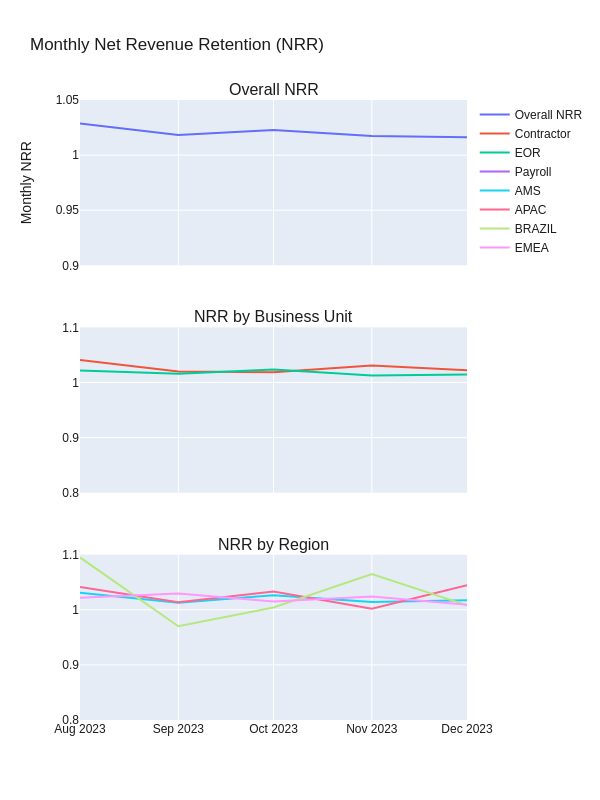

In [ ]:
nrr_business_unit['month'] = pd.to_datetime(nrr_business_unit['month'])
nrr_region['month'] = pd.to_datetime(nrr_region['month'])
nrr_overall['month'] = pd.to_datetime(nrr_overall['month'])

fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=('Overall NRR', 'NRR by Business Unit', 'NRR by Region'),
    shared_xaxes=True,
    vertical_spacing=0.1
)

fig.add_trace(
    go.Scatter(
        x=nrr_overall['month'],
        y=nrr_overall['Monthly_NRR'],
        mode='lines',
        name='Overall NRR',
        line=dict(width=2)
    ),
    row=1, col=1
)

for business_unit in nrr_business_unit['business_unit'].unique():
    subset = nrr_business_unit[nrr_business_unit['business_unit'] == business_unit]
    fig.add_trace(
        go.Scatter(
            x=subset['month'],
            y=subset['Monthly_NRR'],
            mode='lines',
            name=business_unit,
            line=dict(width=2)
        ),
        row=2, col=1
    )

for region in nrr_region['region'].unique():
    subset = nrr_region[nrr_region['region'] == region]
    fig.add_trace(
        go.Scatter(
            x=subset['month'],
            y=subset['Monthly_NRR'],
            mode='lines',
            name=region,
            line=dict(width=2)
        ),
        row=3, col=1
    )


fig.update_layout(
    title='Monthly Net Revenue Retention (NRR)',
    yaxis_title='Monthly NRR',
    height=800,
    width=600,
    font=dict(
            family="Helvetica",
            size=12,
            color="#1b1b1b"
        )
)

fig.update_xaxes(
    tickformat='%b %Y',
    tickvals=pd.date_range(start=min(nrr_business_unit['month'].min(),
                                     nrr_region['month'].min(),
                                     nrr_overall['month'].min()),
                           end=max(nrr_business_unit['month'].max(),
                                    nrr_region['month'].max(),
                                    nrr_overall['month'].max()),
                           freq='MS'),
    ticktext=[d.strftime('%b %Y') for d in pd.date_range(start=min(nrr_business_unit['month'].min(),
                                                                   nrr_region['month'].min(),
                                                                   nrr_overall['month'].min()),
                                                        end=max(nrr_business_unit['month'].max(),
                                                                 nrr_region['month'].max(),
                                                                 nrr_overall['month'].max()),
                                                        freq='MS')]
)

fig.update_yaxes(range=[0.9, 1.05], row=1, col=1)
fig.update_yaxes(range=[0.8, 1.1], row=2, col=1)
fig.update_yaxes(range=[0.8, 1.1], row=3, col=1)

fig.write_image("nrr.png")
display(Image(filename="nrr.png"))

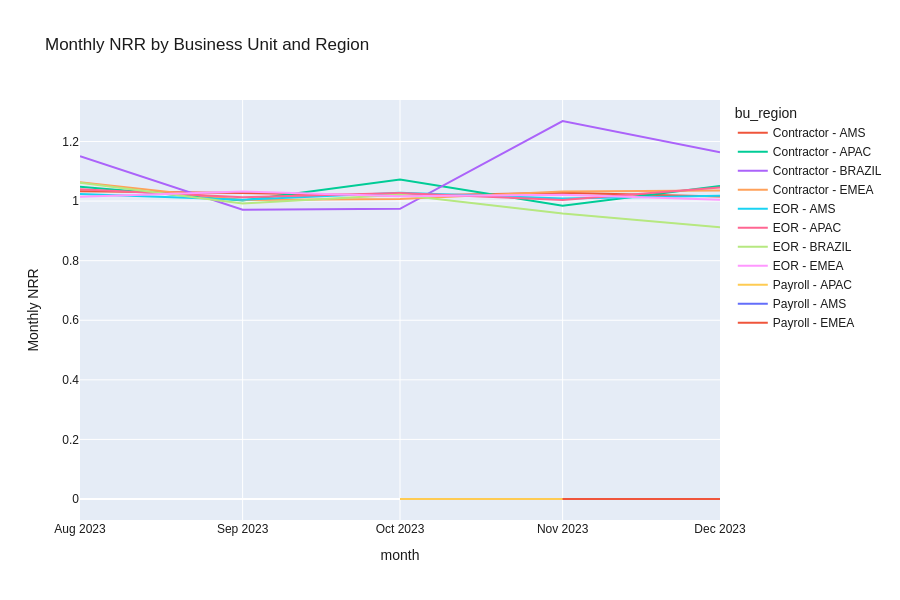

In [ ]:
nrr_regional_bu['bu_region'] = nrr_regional_bu['business_unit'] + ' - ' + nrr_regional_bu['region']

fig = px.line(
    nrr_regional_bu,
    x='month',
    y='Monthly_NRR',
    color='bu_region',
    labels={'Monthly_NRR': 'Monthly NRR'},
    title='Monthly NRR by Business Unit and Region'
)

fig.update_xaxes(
    tickformat='%b %Y',
    tickvals=pd.date_range(start=nrr_regional_bu['month'].min(),
                           end=nrr_regional_bu['month'].max(),
                           freq='MS'),
    ticktext=[d.strftime('%b %Y') for d in pd.date_range(start=nrr_regional_bu['month'].min(),
                                                        end=nrr_regional_bu['month'].max(),
                                                        freq='MS')]
)
fig.update_layout(
    height=600,
    width=900,
    font=dict(
            family="Helvetica",
            size=12,
            color="#1b1b1b"
        )
)
fig.write_image("nrr_by_regional_bu.png")
display(Image(filename="nrr_by_regional_bu.png"))

MRR is monthly recurring revenue from all customers (whereas the customer subset for NRR contains existing active customers). I want to look at how MRR is performing, esp since I think the Payroll product is new; NRR is beneficial for existing customers, but MRR can tell us about the new customers. This query produces the growth in MRR each month and is visualized after.

In [70]:
cursor = conn.cursor()

query = '''
WITH monthly_data AS (
    SELECT
        date(month) AS month
        ,business_unit
        ,region
        ,SUM(TOTAL_SAAS_REVENUE_USD) AS total_SaaS_revenue
    FROM
        cust_rev_mon r
    LEFT JOIN
        dim_serv s
    ON
        r.service_id = s.id
    LEFT JOIN
        dim_cust c
    ON
        r.customer_id = c.customer_id
    GROUP BY
        month
        ,business_unit
        ,region
),
cumulative_mrr AS (
    SELECT
        month
        ,business_unit
        ,region
        ,SUM(total_SaaS_revenue) OVER (PARTITION BY business_unit, region ORDER BY month) AS running_MRR
    FROM
        monthly_data
)
SELECT
    month
    ,business_unit
    ,region
    ,running_MRR
FROM
    cumulative_mrr
ORDER BY
    month
    ,business_unit
    ,region;

'''

cursor.execute(query)
rows = cursor.fetchall()

mrr_regional_bu = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
print(tabulate(mrr_regional_bu, headers="keys", tablefmt="plain"))

    month       business_unit    region         running_MRR
 0  2023-07-01  Contractor                 136572
 1  2023-07-01  Contractor       AMS            7.48692e+06
 2  2023-07-01  Contractor       APAC      533821
 3  2023-07-01  Contractor       BRAZIL    109804
 4  2023-07-01  Contractor       EMEA           2.21869e+06
 5  2023-07-01  EOR                        388182
 6  2023-07-01  EOR              AMS            1.7278e+07
 7  2023-07-01  EOR              APAC           2.75599e+06
 8  2023-07-01  EOR              BRAZIL    227700
 9  2023-07-01  EOR              EMEA           1.31748e+07
10  2023-08-01  Contractor                 274384
11  2023-08-01  Contractor       AMS            1.54145e+07
12  2023-08-01  Contractor       APAC           1.09508e+06
13  2023-08-01  Contractor       BRAZIL    239634
14  2023-08-01  Contractor       EMEA           4.58797e+06
15  2023-08-01  EOR                        784555
16  2023-08-01  EOR              AMS            3.51038e+07
1

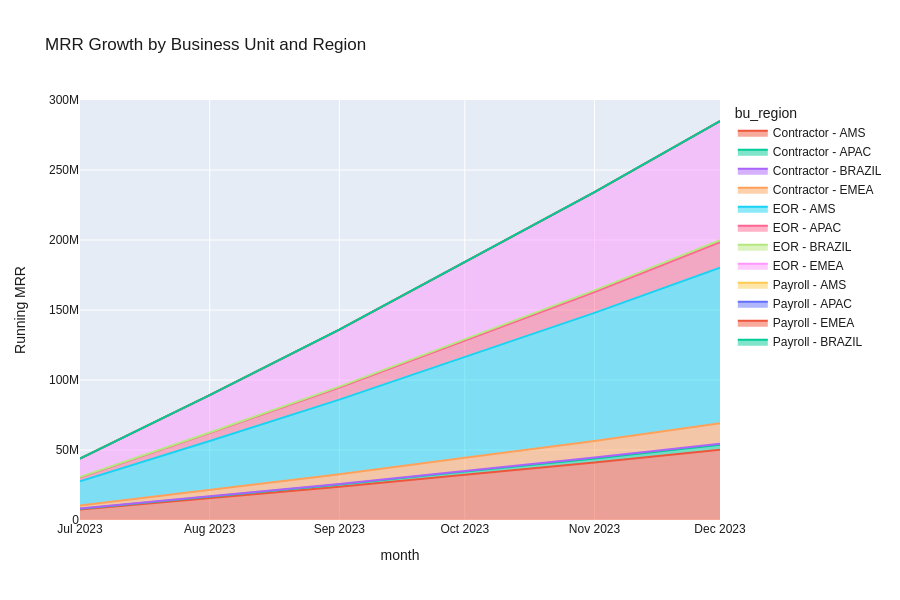

In [ ]:
mrr_regional_bu['bu_region'] = mrr_regional_bu['business_unit'] + ' - ' + mrr_regional_bu['region']
fig = px.area(
    mrr_regional_bu,
    x='month',
    y='running_MRR',
    color='bu_region',
    labels={'running_MRR': 'Running MRR'},
    title='MRR Growth by Business Unit and Region'
)
fig.update_layout(
    height=600,
    width=900,
    font=dict(
            family="Helvetica",
            size=12,
            color="#1b1b1b"
        )
)
fig.write_image("mrr_by_regional_bu.png")
display(Image(filename="mrr_by_regional_bu.png"))

This particular analysis can be improved with a longer time period and by looking at the MRR by cohort; this would require having several years of data along with the account registration data for each customer. I would adapt the dataviz to display the running MRR by cohort for the top-performing (EOR - AMS, EOR - EMEA) & bottom-performing services (Payroll).

In [ ]:
conn.close()